# Parse and align Spike sequences

## Imports and configuration
Import modules and read configuration file:

In [1]:
import os

import Bio.Entrez
import Bio.SeqIO

import matplotlib.pyplot as plt

import pandas as pd

from plotnine import *

Specify configuration options:

In [2]:
# names of input files
genbank_accession_table = 'data/Genbank_229E_accessions.csv'  # accessions and metadata

# options
redownload_genbank = False  # fresh download if Genbank accession already downloaded
Bio.Entrez.email = 'jbloom@fredhutch.org'  # e-mail used for Genbank downloads
prot_length_range = (1170, 1174)  # keep Spikes in this protein length range (inclusive)

# names of created results directories / files
results_dir = './results/'  # results go here
genbank_seqs_dir = os.path.join(results_dir, 'genbank_seqs')  # download sequences here

# create directories
for dirname in [results_dir, genbank_seqs_dir]:
    os.makedirs(dirname, exist_ok=True)

## Download and parse Spike sequences
Read the CSV giving the Genbank accessions, then download all the Genbank sequences:

In [3]:
acc_df = pd.read_csv(genbank_accession_table)
assert acc_df['Accession'].nunique() == len(acc_df)
assert all(acc_df['Host'] == 'Homo sapiens')

acc_to_file = {acc: os.path.join(genbank_seqs_dir, f"{acc}.gb")
               for acc in acc_df['Accession']}
missing_accessions = {acc: f for acc, f in acc_to_file.items() if not os.path.isfile(f)}
print(f"There are {len(acc_to_file)} accessions in {genbank_accession_table}, of which "
      f"{len(missing_accessions)} are not already downloaded in {genbank_seqs_dir}.")
if redownload_genbank:
    to_download = acc_to_file
    print(f"Downloading all {len(to_download)} accessions (overwriting any existing ones).")
else:
    to_download = missing_accessions
    print(f"Downloading the {len(to_download)} accessions not already in {genbank_seqs_dir}.")

update_every = 25
for i, (acc, fname) in enumerate(to_download.items()):
    if i % update_every == 0:
        print(f"Progress: accession {i + 1} of {len(to_download)}")
    gb_text = Bio.Entrez.efetch(db='nucleotide',
                                id=acc,
                                rettype='gb',
                                retmode='text',
                                ).read()
    with open(fname, 'w') as f:
        f.write(gb_text)

There are 303 accessions in data/Genbank_229E_accessions.csv, of which 0 are not already downloaded in ./results/genbank_seqs.


Make a data frame that has a row for each CDS in each Genbank accession (these accessions often represent many CDSs), identify what products these CDSs correspond to, and extract the CDS sequence.
Furthermore, use the CDS product name to determine if it is Spike.
After doing this, we plot the number of CDSs for each product name, colored by whether they are Spike.
Look at this plot to make sure that everything colored as Spike indeed appears to be Spike, and everything **not** colored as Spike is not Spike:

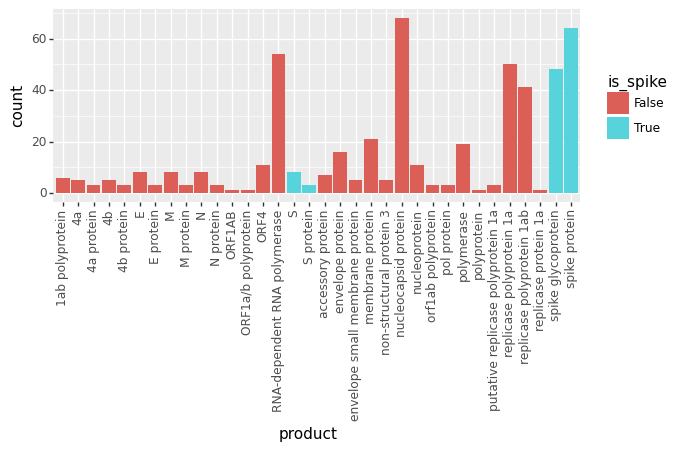

In [4]:
cds_df = (
    acc_df
    .assign(SeqRecord=lambda x: (x['Accession']
                                 .map(acc_to_file)
                                 .apply(Bio.SeqIO.read, format='gb')
                                 ),
            cds_features=lambda x: x['SeqRecord'].map(lambda s: [f for f in s.features if f.type == 'CDS']),
            n_cds_features=lambda x: x['cds_features'].map(len)
            )
    .query('n_cds_features > 0')
    .explode('cds_features')
    .rename(columns={'cds_features': 'cds_feature'})
    .assign(product=lambda x: x['cds_feature'].map(lambda f: f.qualifiers['product'][0]),
            sequence=lambda x: x.apply(lambda r: r['cds_feature'].extract(r['SeqRecord']).seq,
                                       axis=1),
            sequence_length=lambda x: x['sequence'].map(len),
            is_spike=lambda x: x['product'].str.match('^(S|s)'),
            )
    )

p = (ggplot(cds_df) +
     aes('product', fill='is_spike') +
     geom_bar() +
     theme(axis_text_x=element_text(angle=90),
           figure_size=(0.2 * cds_df['product'].nunique(), 2.5))
     )
_ = p.draw()

Now get a data frame that is just Spike, filtering just to those of valid lengths, and checking for problematic features like premature stop codons or ambiguous nucleotides:

Here is plot of number of Spikes at each protein length; only keeping those with valid length:


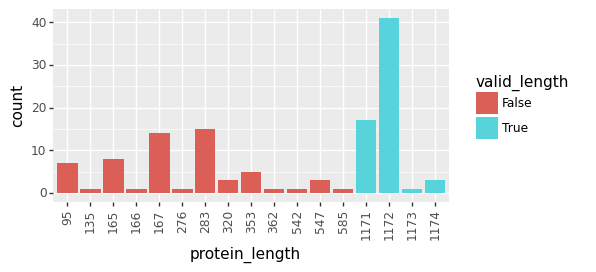


Removing 0 of 62 Spikes for failing premature_stop filter.

Removing 2 of 62 Spikes for failing ambiguous_nts filter.
Here are the sequences being filtered:


,Accession,Authors,Geo_Location,country,Isolation_Source,collection_date,GenBank_Title,sequence,protein
3,MT438699,"Dinwiddie,D.L., Dehority,W.N., Schwalm,K.C., K...","USA: Little Rock, Arkansas",USA,oronasopharynx,2017-02-27,Human coronavirus 229E isolate HCoV-229E/USA/A...,ATGTTTGTTTTACTTGTTGCATATGCCTTGTTGCATATTGCTGGTT...,MFVLLVAYALLHIAGCQTTNGTNTSHSVCNGCVGHSENVFAVESGG...
270,JX503060,"Farsani,S.M., Dijkman,R., Jebbink,M.F., Goosse...",Netherlands,Netherlands,oronasopharynx,2010-01-01,"Human coronavirus 229E isolate 0349, complete ...",ATGTTTGTTTTACTTGTTGCATATGCCTTGTTGCATATTGCTGGTT...,MFVLLVAYALLHIAGCQTTNGTNTSHSVCNGCVGHSENVFAVESGG...



Removing 3 of 60 Spikes for failing no_collection_date filter.
Here are the sequences being filtered:


,Accession,Authors,Geo_Location,country,Isolation_Source,collection_date,GenBank_Title,sequence,protein
257,KF293664,"Lundin,A., Dijkman,R., Bergstrom,T., Kann,N., ...",Sweden,Sweden,NaN,NaT,"Human coronavirus 229E clone p0, partial genome",ATGTTTGTTTTGCTTGTTGCATATGCCTTGTTGCATATTGCTGGTT...,MFVLLVAYALLHIAGCQTTNGLNTSYSVCNGCVGYSENVFAVESGG...
258,KF293665,"Lundin,A., Dijkman,R., Bergstrom,T., Kann,N., ...",Sweden,Sweden,NaN,NaT,"Human coronavirus 229E clone mock-p11, partial...",ATGTTTGTTTTGCTTGTTGCATATGCCTTGTTGCATATTGCTGGTT...,MFVLLVAYALLHIAGCQTTNGLNTSYSVCNGCVGYSENVFAVESGG...
259,KF293666,"Lundin,A., Dijkman,R., Bergstrom,T., Kann,N., ...",Sweden,Sweden,NaN,NaT,"Human coronavirus 229E clone K22-p11, partial ...",ATGTTTGTTTTGCTTGTTGCATATGCCTTGTTGCATATTGCTGGTT...,MFVLLVAYALLHIAGCQTTNGLNTSYSVCNGCVGYSENVFAVESGG...



Overall, retained 57 Spikes.


In [5]:
spike_df = (
    cds_df
    .query('is_spike == True')
    .assign(protein=lambda x: x['sequence'].map(lambda s: s[: (len(s) // 3) * 3].translate()).map(str),
            protein_length=lambda x: x['protein'].map(len),
            valid_length=lambda x: x['protein_length'].map(lambda n: prot_length_range[0] <= n <= prot_length_range[1]),
            premature_stop=lambda x: x['protein'].str[: -1].str.contains('*', regex=False),
            sequence=lambda x: x['sequence'].map(str),
            ambiguous_nts=lambda x: x['sequence'].str.contains('[^ACGT]'),
            country=lambda x: x['Geo_Location'].str.split(':').map(lambda y: y[0]),
            collection_date=lambda x: pd.to_datetime(x['Collection_Date']),
            no_collection_date=lambda x: x['collection_date'].isnull(),
            )
    )

print('Here is plot of number of Spikes at each protein length; only keeping those with valid length:')
p = (ggplot(spike_df.assign(protein_length=lambda x: pd.Categorical(x['protein_length']))) +
     aes('protein_length', fill='valid_length') +
     geom_bar() +
     theme(axis_text_x=element_text(angle=90),
           figure_size=(0.3 * spike_df['protein_length'].nunique(), 2.5),
           )
     ).draw()
display(p)
plt.close(p)

spike_df = spike_df.query('valid_length')

# columns we keep to print
cols_of_interest = ['Accession', 'Authors', 'Geo_Location', 'country', 'Isolation_Source',
                    'collection_date', 'GenBank_Title', 'sequence', 'protein']

for filter_criteria in ['premature_stop', 'ambiguous_nts', 'no_collection_date']:
    df_fail = spike_df.query(filter_criteria)
    print(f"\nRemoving {len(df_fail)} of {len(spike_df)} Spikes for failing {filter_criteria} filter.")
    if len(df_fail):
        print('Here are the sequences being filtered:')
        display(df_fail[cols_of_interest])
        spike_df = spike_df.query(f"not {filter_criteria}")

print(f"\nOverall, retained {len(spike_df)} Spikes.")
spike_df = spike_df[cols_of_interest].reset_index(drop=True)

Plot Spike sequence isolation year and location (country):

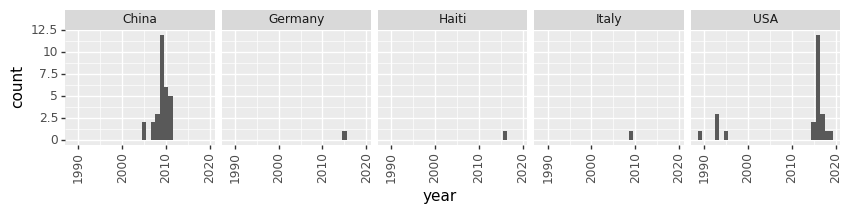

In [6]:
p = (ggplot(spike_df.assign(year=lambda x: x['collection_date'].dt.year)) +
     aes('year') +
     geom_histogram(binwidth=1) +
     facet_wrap('~ country', nrow=1) +
     theme(axis_text_x=element_text(angle=90),
           figure_size=(2 * spike_df['country'].nunique(), 1.5),
           )
     )

_ = p.draw()